# Twitter Trends/Tweets Archiver Development
Ryan Skinner, March 2019

## Objectives
This notebook serves as a playground for getting Twitter API calls working in Python, with the ultimate goal of archiving trends and tweets to an Amazon S3 bucket.

Specifically, we have four objectives:
1. Establish an authenticated connection with the Twitter API using oauth2
1. Query the Twitter/Trends API and select top-X trending hashtags in the US
1. Query the Twitter/Search API for each top-X trend to get relevant tweets in the US
1. Archive trends and tweets to S3

Once these objectives are achieved in this Jupyter Notebook, we'll package everything in a service that can be run in the background on an EC2 instance. [Many libraries exist for Twitter API calls in Python](https://developer.twitter.com/en/docs/developer-utilities/twitter-libraries.html), but we choose to use [Birdy](https://github.com/inueni/birdy) due to its simplicity.

## 1. Authenticate to Twitter API

We have created a Twitter developer account, as well as an app within that account. We wish to make calls to the Twitter API using [application-only authentication](https://developer.twitter.com/en/docs/basics/authentication/overview/application-only), since we do not wish to make calls that are associated with any specific user. Application calls also have a higher rate-limit on requests to the search/tweets endpoint.

Most of the following is automatically handled by [Birdy](https://github.com/inueni/birdy), but we describe the process in some detail for better understanding.

#### OAuth

Twitter has a nice explanation of the authentication flow at the above link, which follows these steps:

1. An application encodes its consumer key and secret key into a specially encoded set of credentials.
2. An application makes a request to the POST oauth2 / token endpoint to exchange these credentials for a bearer token.
3. When accessing the REST API, the application uses the bearer token to authenticate.

This [website has a nice overview of using OAuth in Python](https://requests-oauthlib.readthedocs.io/en/latest/oauth2_workflow.html#backend-application-flow).

#### Credentials as Environment Variables

All three credentials (the consumer key, secret key, and bearer token) give access to the Twitter API on behalf of the application, and should be considered as sensitive as passwords. **As such, we will store all three credentials as environment variables so they are not included in our code on GitHub.**

For testing purposes, we launch this Jupyter Notebook from `bash` with a modified environment with

>`env TWITTER_API_KEY=xxxxx TWITTER_API_KEY_SECRET=xxxxx jupyter notebook`

where the `xxxxx`'s are replaced with the values found on the Keys and Tokens tab of your application's page on https://developer.twitter.com/.

#### Transport Layer Security (TLS) Required

All requests to Twitter API endpoints, including to obtain and use tokens, [must use HTTPS endpoints](https://developer.twitter.com/en/docs/basics/authentication/guides/tls). Twitter advocates best practices for verifying certificates; see the aforementioned link.

#### Rate Limiting

A Twitter API exists that will return the [current status of rate-limiting for an application](https://developer.twitter.com/en/docs/developer-utilities/rate-limit-status/api-reference/get-application-rate_limit_status). Specifically, it will tell you the limit for each specified Twitter API endpoint, the number of requests remaining, and the duration in UNIX epoch seconds before the rate limit resets. See [documentation on fields returned by the rate_limit_status API here](https://developer.twitter.com/en/docs/basics/rate-limiting.html).

#### Start Coding!

Now that we have some preliminaries out of the way, let's start using Birdy to make requests.

In [1]:
import os
from birdy.twitter import AppClient

# Load consumer keys from environment variables.
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')

# Ensure API keys are present in environment variables.
print('Twitter API        key loaded?', consumer_key != 'None')
print('Twitter API secret key loaded?', consumer_secret != 'None')

Twitter API        key loaded? True
Twitter API secret key loaded? True


With consumer keys loaded, let's set up authenticated requests.

In [2]:
# Initialize our client object with consumer keys.
client = AppClient(consumer_key, consumer_secret)

# Obtain the OAuth2 access token using our consumer keys.
access_token = client.get_access_token()

# Re-initialize our client object that stores the access token for later use.
client = AppClient(consumer_key, consumer_secret, access_token)

## 2. Hit Twitter's `trends/available` Endpoint

This endpoint returns the locations for which Twitter has trending topic information available.

In [3]:
resource_trends_available = client.api.trends.available

response_global = resource_trends_available.get()

In [4]:
print('Number of locations globally:', len(response_global.data))
response_global.data

Number of locations globally: 467


[{'name': 'Worldwide',
  'placeType': {'code': 19, 'name': 'Supername'},
  'url': 'http://where.yahooapis.com/v1/place/1',
  'parentid': 0,
  'country': '',
  'woeid': 1,
  'countryCode': None},
 {'name': 'Winnipeg',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2972',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 2972,
  'countryCode': 'CA'},
 {'name': 'Ottawa',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3369',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 3369,
  'countryCode': 'CA'},
 {'name': 'Quebec',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3444',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 3444,
  'countryCode': 'CA'},
 {'name': 'Montreal',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3534',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 3534,
  'co

There are currently 467 locations for which Twitter has trending topic information available.

In [5]:
response_usa = [x for x in response_global.data if x.country == 'United States']

print('Number of locations in USA:', len(response_usa))
response_usa

Number of locations in USA: 64


[{'name': 'Albuquerque',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2352824',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2352824,
  'countryCode': 'US'},
 {'name': 'Atlanta',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2357024',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2357024,
  'countryCode': 'US'},
 {'name': 'Austin',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2357536',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2357536,
  'countryCode': 'US'},
 {'name': 'Baltimore',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2358820',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2358820,
  'countryCode': 'US'},
 {'name': 'Baton Rouge',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2359

Of these 467 global locations, 64 are in the USA. Furthermore, we notice that all USA locations with trending hashtags available are cities, save for one entry which corresponds to the entire country.

Let's collect a list of all the `woeid`s corresponding to these USA-based towns (excluding the one woeid that represents the country).

In [6]:
woeids_usa = [x.woeid for x in response_usa if x.placeType.name == 'Town']
print(len(woeids_usa))
woeids_usa

63


[2352824,
 2357024,
 2357536,
 2358820,
 2359991,
 2364559,
 2367105,
 2378426,
 2379574,
 2380358,
 2381475,
 2383489,
 2383660,
 2388929,
 2391279,
 2391585,
 2397816,
 2407517,
 2414469,
 2418046,
 2423945,
 2424766,
 2427032,
 2428184,
 2428344,
 2430683,
 2436704,
 2441472,
 2442047,
 2442327,
 2449323,
 2449808,
 2450022,
 2451822,
 2452078,
 2457170,
 2458410,
 2458833,
 2459115,
 2460389,
 2464592,
 2465512,
 2466256,
 2471217,
 2471390,
 2473224,
 2475687,
 2477058,
 2478307,
 2480894,
 2486340,
 2486982,
 2487610,
 2487796,
 2487889,
 2487956,
 2488042,
 2490383,
 2503713,
 2503863,
 2508428,
 2512636,
 2514815]

## 3. Hit Twitter's `trends/place` Endpoint

And now we hit Twitter's GET trends/place endpoint to obtain a list of trending hashtags for each USA-based `woeid` we just found.

This endpoint is limited to 75 requests per 15-minute window for both users and apps. Luckily, we have only 64 locations in the USA, so we should be able to hit each at a rate of once per 15 minutes.

#### Single `woeid`

For development purposes, we'll start by hitting the endpoint for only one test `woeid`.

In [7]:
woeid_test = 23424977 # United States

In [8]:
resource_trends_place = client.api.trends.place
response_test = resource_trends_place.get(id=woeid_test)

In [9]:
import json

print(json.dumps(response_test.data, indent=4))

[
    {
        "trends": [
            {
                "name": "#FakeMelania",
                "url": "http://twitter.com/search?q=%23FakeMelania",
                "promoted_content": null,
                "query": "%23FakeMelania",
                "tweet_volume": 46903
            },
            {
                "name": "#theravencycle",
                "url": "http://twitter.com/search?q=%23theravencycle",
                "promoted_content": null,
                "query": "%23theravencycle",
                "tweet_volume": null
            },
            {
                "name": "#SaturdayThoughts",
                "url": "http://twitter.com/search?q=%23SaturdayThoughts",
                "promoted_content": null,
                "query": "%23SaturdayThoughts",
                "tweet_volume": 41951
            },
            {
                "name": "BIG 12 CHAMPS",
                "url": "http://twitter.com/search?q=%22BIG+12+CHAMPS%22",
                "promoted_content": null

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

trend_names = np.array([x.name for x in response_test.data[0].trends])
trend_vols = np.array([x.tweet_volume for x in response_test.data[0].trends])
len_trend_names_orig = len(trend_names)

trend_names = trend_names[trend_vols != None]
trend_vols = trend_vols[trend_vols != None]

order = np.flip(np.argsort(trend_vols), axis=0)
trend_names = trend_names[order]
trend_vols = trend_vols[order]

plt.figure(figsize=[8, 0.3 * len(order)])
sns.barplot(x=trend_vols, y=trend_names, ax=plt.gca())
plt.xlabel('Tweet Volume')
plt.title('Fraction of trends with nonzero volume: {:d} / {:d}'.format(len(trend_names), len_trend_names_orig))
plt.show()

<Figure size 800x270 with 1 Axes>

Querying this endpoint during testing, it looks like the output can change  by a fairly large amount over the course of just one hour. This is why 15-minute resolution will likely be beneficial.

#### Multiple `woeid`s

Now we'll actually build the solution we need for multiple `woeid`s. That is, given a list of `woeid`s, query trends for each, sort by tweet volume, and select the $x$ highest-volume trends.

In [11]:
woeids_test = [2352824, 2357024, 2357536, 2358820, 2359991]

In [12]:
trend_names = []
trend_vols = []

# For each woeid, query trends/place and store trend names and volumes
for woeid in woeids_test:
    response_trends_place = resource_trends_place.get(id=woeid)
    trend_names += [x.name for x in response_test.data[0].trends]
    trend_vols += [x.tweet_volume for x in response_test.data[0].trends]

# Convert to numpy arrays
trend_names = np.array(trend_names)
trend_vols = np.array(trend_vols)

# Remove entries where trend volumes are unavailable
not_nones = trend_vols != None
trend_names = trend_names[not_nones]
trend_vols = trend_vols[not_nones]

In [13]:
# Multiple cities will have the same trends, so reduce by summing volumes for common keys
from collections import Counter
c = Counter()
for name, vol in zip(trend_names, trend_vols):
    c[name] += vol

In [14]:
def plot_counter(counter, n=None):
    '''Calls seaborn.barplot to visualize n-largest items in a Counter'''
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    c_sorted = counter.most_common(n)
    sns.barplot(x=[a[1] for a in c_sorted], y=[a[0] for a in c_sorted], ax=plt.gca())

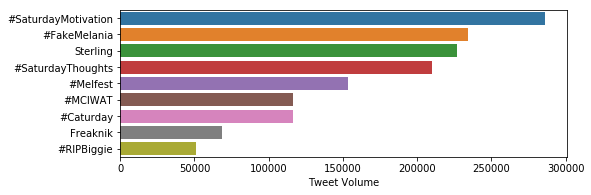

In [15]:
plt.figure(figsize=[8, 0.3 * len(c)])
plot_counter(c)
plt.xlabel('Tweet Volume')
plt.show()

In [16]:
top_trends = [x[0] for x in c.most_common(n=5)]
top_trends

['#SaturdayMotivation',
 '#FakeMelania',
 'Sterling',
 '#SaturdayThoughts',
 '#Melfest']

## 4. Hit Twitter's `search/tweets` Endpoint

For each location in the US, and for each of the trending topics above, we want to search for tweets containing these trends so we can store them for later sentiment analysis.

- The `search/tweets` endpoint has a request limit of 450 / 15-min using app auth, and up to 100 tweets can be returned with each search.
- We can also specify a location to search with the `geocode lat,lon,radius` option.

#### Coordinates of 90 Cities

Given only the top-5 trends, we can query each trend from 90 cities once per 15-min interval. The 90 cities to use will comprise...

1. the most populous city in each of the 50 US states, plus...
1. the 40 most populous cities in the US that are not the most populous city in their state

Let's quickly generate this list of 90 cities. We'll start from this [csv file of the 1000 largest cities in the US](https://gist.github.com/Miserlou/11500b2345d3fe850c92).

In [17]:
import pandas as pd

# Load and remove District of Columbia
cities_raw = pd.read_csv('cities_top1000.csv')
cities_raw = cities_raw[cities_raw.state != 'District of Columbia']
cities_raw.sort_values(by='population', ascending=False, inplace=True)

cities_raw.sample(n=5).sort_values('rank')

,rank,city,state,population,2000-2013growth
310,311,Dearborn,Michigan,95884,-2.0%
543,543,Delray Beach,Florida,64072,6.1%
911,912,Crystal Lake,Illinois,40388,5.3%
921,922,Florence,Alabama,40059,10.2%
964,965,Carpentersville,Illinois,38241,22.8%


In [20]:
cities_first50 = cities_raw.drop_duplicates(['state'])
cities_next40 = pd.concat([cities_raw, cities_first50]).drop_duplicates(keep=False).iloc[:40]
cities_all90 = pd.concat([cities_first50, cities_next40])
cities_all90 = cities_all90[['city', 'state', 'population']].reset_index(drop=True)
cities_all90.shape

(90, 3)

In [25]:
for r in cities_all90.iterrows():
    print('{:s}, {:s}'.format(r[1][0], r[1][1]))

New York, New York
Los Angeles, California
Chicago, Illinois
Houston, Texas
Philadelphia, Pennsylvania
Phoenix, Arizona
Indianapolis, Indiana
Jacksonville, Florida
Columbus, Ohio
Charlotte, North Carolina
Detroit, Michigan
Memphis, Tennessee
Seattle, Washington
Denver, Colorado
Boston, Massachusetts
Baltimore, Maryland
Oklahoma City, Oklahoma
Louisville/Jefferson County, Kentucky
Portland, Oregon
Las Vegas, Nevada
Milwaukee, Wisconsin
Albuquerque, New Mexico
Kansas City, Missouri
Virginia Beach, Virginia
Atlanta, Georgia
Omaha, Nebraska
Minneapolis, Minnesota
Wichita, Kansas
New Orleans, Louisiana
Honolulu, Hawaii
Anchorage, Alaska
Newark, New Jersey
Boise City, Idaho
Birmingham, Alabama
Des Moines, Iowa
Little Rock, Arkansas
Salt Lake City, Utah
Providence, Rhode Island
Jackson, Mississippi
Sioux Falls, South Dakota
Bridgeport, Connecticut
Columbia, South Carolina
Fargo, North Dakota
Manchester, New Hampshire
Billings, Montana
Wilmington, Delaware
Portland, Maine
Cheyenne, Wyoming
Cha

Now that we have our desired 90 cities, we need to get their associated latitutes and longitudes. To do this, we tried a bunch of different options but the one that *finally* worked was [GeoCoder](https://batchgeo.com/), which succeeded in giving us GPS coordinates for the 90 city names we generated below. We then downloaded the map as a `.kml` file, which has XML representations of placenames and coordinates. Then we used `vim` to remove unnessary xml data and condense information about city, state, latitude, and longitude into the following file.

In [38]:
!cat cities_all90.csv | shuf | head

Fort Worth,Texas,-97.3307658,32.7554883
Seattle,Washington,-122.3320708,47.6062095
Arlington,Texas,-97.1080656,32.735687
Philadelphia,Pennsylvania,-75.1652215,39.9525839
Wilmington,Delaware,-75.5483909,39.744655
Baltimore,Maryland,-76.6121893,39.2903848
Cincinnati,Ohio,-84.5120196,39.1031182
New York,New York,-74.0059728,40.7127753
Columbus,Ohio,-82.9987942,39.9611755
Atlanta,Georgia,-84.3879824,33.7489954


In [34]:
cities_coords = pd.read_csv('cities_all90.csv', names=['city', 'state', 'longitude', 'latitude'])
cities_coords

,city,state,longitude,latitude
0,New York,New York,-74.005973,40.712775
1,Los Angeles,California,-118.243685,34.052234
2,Chicago,Illinois,-87.629798,41.878114
3,Houston,Texas,-95.369803,29.760427
4,Philadelphia,Pennsylvania,-75.165222,39.952584
5,Phoenix,Arizona,-112.074037,33.448377
6,Indianapolis,Indiana,-86.158068,39.768403
7,Jacksonville,Florida,-81.655651,30.332184
8,Columbus,Ohio,-82.998794,39.961176
9,Charlotte,North Carolina,-80.843127,35.227087


Let's do a quick visualization of the cities.

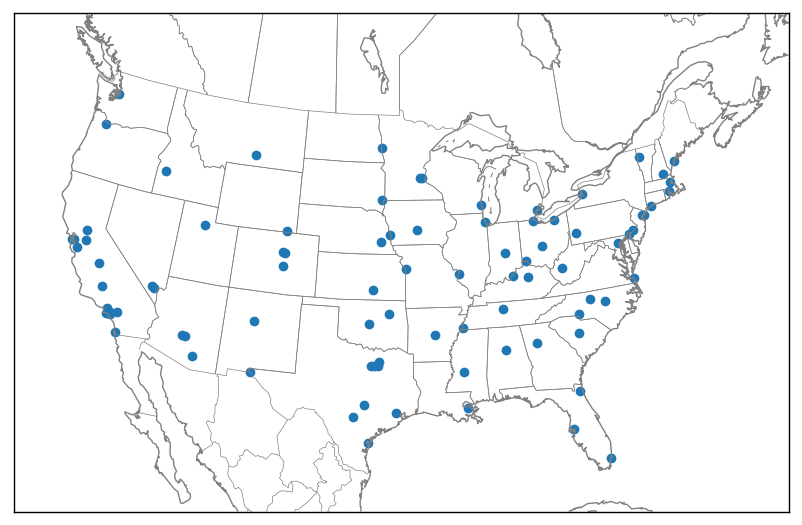

In [37]:
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10, 10), dpi=100)
m = Basemap(projection='lcc', resolution='l', area_thresh=1e4, width=5.6e6, height=3.6e6, lat_0=39.5, lon_0=-95)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(cities_coords.longitude.tolist(), cities_coords.latitude.tolist(), latlon=True)
plt.show()

This looks good enough. Some cities are about 15 miles apart, and these constitute the same metro area. We can still keep the radius for tweet-querying at around 20 miles, though, since there's likely little difference from city-to-city, and this is a good enough spread of cities across the US to be interesting.

#### Query Tweets from 90 Cities

And now, finally, we can start querying tweets. Specifically, within a 20-mile radius of each city for each trend of interest.